0:	test: 0.9771180	best: 0.9771180 (0)	total: 11.4s	remaining: 37m 50s
100:	test: 0.9907386	best: 0.9907386 (100)	total: 16m 57s	remaining: 16m 37s
199:	test: 0.9940776	best: 0.9940776 (199)	total: 32m 16s	remaining: 0us

bestTest = 0.9940776064
bestIteration = 199


CatBoost Results


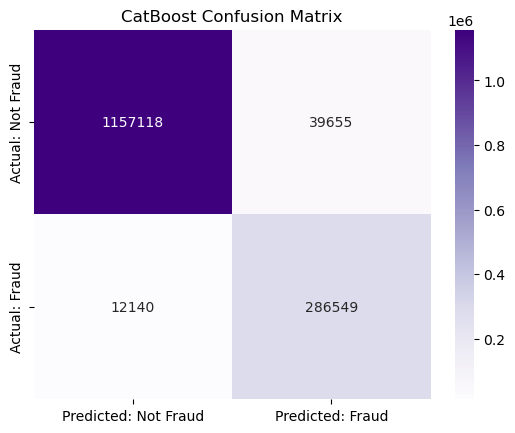


Classification Report (CatBoost):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.97      0.98   1196773
       Fraud       0.88      0.96      0.92    298689

    accuracy                           0.97   1495462
   macro avg       0.93      0.96      0.95   1495462
weighted avg       0.97      0.97      0.97   1495462

ROC AUC Score (CatBoost): 0.994078


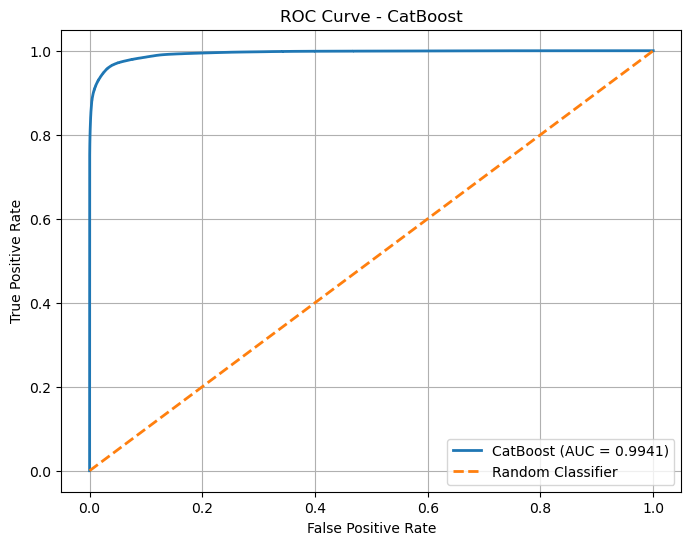

In [1]:
# ---------------------------------
# CatBoost Model
# ---------------------------------

!pip install catboost

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------
# Load dataset
# ---------------------------------
df_catboost = pd.read_csv('fraud_data_catboost.csv')

X = df_catboost.drop(columns=['is_fraud'])
y = df_catboost['is_fraud']

# ---------------------------------
# Train-test split
# ---------------------------------
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ---------------------------------
# Handle class imbalance
# ---------------------------------
scale_pos_weight_cat = (y_train_cat == 0).sum() / (y_train_cat == 1).sum()

# ---------------------------------
# Categorical columns (STRING columns)
# ---------------------------------
cat_features = [
    'merchant_category',
    'merchant_type',
    'country',
    'currency',
    'device',
    'channel',
    'merchant',
    'card_type',
    'card_present',
    'high_risk_merchant',
    'weekend_transaction'
]

# ---------------------------------
# Train CatBoost
# ---------------------------------
model_cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=scale_pos_weight_cat,
    eval_metric='AUC',
    cat_features=cat_features,
    loss_function='Logloss',
    random_seed=42,
    verbose=100
)

model_cat.fit(
    X_train_cat,
    y_train_cat,
    eval_set=(X_test_cat, y_test_cat),
    early_stopping_rounds=50
)

# ---------------------------------
# Predictions
# ---------------------------------
y_pred_cat = model_cat.predict(X_test_cat)
y_proba_cat = model_cat.predict_proba(X_test_cat)[:, 1]

# ---------------------------------
# Evaluation
# ---------------------------------
print("\nCatBoost Results")

cm_cat = confusion_matrix(y_test_cat, y_pred_cat)

sns.heatmap(
    pd.DataFrame(
        cm_cat,
        index=['Actual: Not Fraud', 'Actual: Fraud'],
        columns=['Predicted: Not Fraud', 'Predicted: Fraud']
    ),
    annot=True,
    fmt='d',
    cmap='Purples'
)
plt.title("CatBoost Confusion Matrix")
plt.show()

print("\nClassification Report (CatBoost):")
print(classification_report(y_test_cat, y_pred_cat, target_names=['Not Fraud', 'Fraud']))

roc_auc_cat = roc_auc_score(y_test_cat, y_proba_cat)
print(f"ROC AUC Score (CatBoost): {roc_auc_cat:.6f}")

# ---------------------------------
# ROC Curve
# ---------------------------------
fpr_cat, tpr_cat, _ = roc_curve(y_test_cat, y_proba_cat)
roc_auc_cat_curve = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr_cat,
    tpr_cat,
    lw=2,
    label=f'CatBoost (AUC = {roc_auc_cat_curve:.4f})'
)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
